In [68]:
import json
import ast
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import folium
from folium.plugins import MarkerCluster
import datetime

In [69]:
def get_data():

    df = pd.read_csv('bird_data.csv')
    df.drop(['code', 'captive'], axis=1, inplace=True)

    temp_df = df.head(200000)

    new_df = add_lat_long(temp_df)
    new_df['count'] = 1
    new_df['grid_location'] = 0
    new_df.drop(['location'], axis=1, inplace=True)
    return new_df

In [70]:
def add_lat_long(df):
    loc_array = df['location']
    
    loc_list= []
    for i in loc_array:
        loc_list.append(ast.literal_eval(i))
    
    df = pd.concat([df, pd.DataFrame(loc_list)], axis=1)
    df['latitude'] = df['latitude'].round(5)
    df['longitude'] = df['longitude'].round(5)
    return df

In [71]:
def get_geojson_grid(upper_right, lower_left, n=6):
    """Returns a grid of geojson rectangles, and computes the exposure in each section of the grid based on the vessel data.

    Parameters
    ----------
    upper_right: array_like
        The upper right hand corner of "grid of grids" (the default is the upper right hand [lat, lon] of the USA).

    lower_left: array_like
        The lower left hand corner of "grid of grids"  (the default is the lower left hand [lat, lon] of the USA).

    n: integer
        The number of rows/columns in the (n,n) grid.

    Returns
    -------

    list
        List of "geojson style" dictionary objects   
    """

    all_boxes = []

    lat_steps = np.linspace(lower_left[0], upper_right[0], n+1)
    lon_steps = np.linspace(lower_left[1], upper_right[1], n+1)

    lat_stride = lat_steps[1] - lat_steps[0]
    lon_stride = lon_steps[1] - lon_steps[0]

    for lat in lat_steps[:-1]:
        for lon in lon_steps[:-1]:
            # Define dimensions of box in grid
            upper_left = [lon, lat + lat_stride]
            upper_right = [lon + lon_stride, lat + lat_stride]
            lower_right = [lon + lon_stride, lat]
            lower_left = [lon, lat]

            # Define json coordinates for polygon
            coordinates = [
                upper_left,
                upper_right,
                lower_right,
                lower_left,
                upper_left
            ]

            geo_json = {"type": "FeatureCollection",
                        "properties":{
                            "lower_left": lower_left,
                            "upper_right": upper_right
                        },
                        "features":[]}

            grid_feature = {
                "type":"Feature",
                "geometry":{
                    "type":"Polygon",
                    "coordinates": [coordinates],
                }
            }

            geo_json["features"].append(grid_feature)

            all_boxes.append(geo_json)

    return all_boxes

In [142]:
def add_grid_location(df, n=42):
    
    '''
    Assigns each data point to a location on the grid according to its lat/long
    '''
    
    top_right = [df['latitude'].max(), df['longitude'].max()]
    top_left = [df['latitude'].min(), df['longitude'].min()]
    
    grid = get_geojson_grid(top_right, top_left, n)
    
    for i, box in enumerate(grid):
        upper_right = box["properties"]["upper_right"]
        lower_left = box["properties"]["lower_left"]
    
        mask = (
            (df.latitude <= upper_right[1]) & (df.latitude >= lower_left[1]) &
            (df.longitude <= upper_right[0]) & (df.longitude >= lower_left[0])
           )
    
        column_name = 'grid_location'
        df.loc[mask, column_name] = i
    
    return df

In [73]:
def add_time_chunk(df):
    df['time_chunk'] = 0
    for i, time in enumerate(df['time'].unique()):
        df['time_chunk'][df['time'] == time] = i
    return df

In [74]:
def add_day_of_week(df):
    df['date'] = pd.to_datetime(df['time']).dt.round("D")
    df['day_of_week'] = df['date'].dt.day_name()
    
    return df

In [75]:
def add_rounded_time(df, interval=15):
    '''
    Adds a column with the rounded time to the interval specified.
    
    '''
    df['rounded_time'] = pd.to_datetime(df['time']).dt.round('15min')  
    #df['rounded_time'] = pd.to_datetime(df['time']).dt.round("Min").apply(lambda dt: datetime.datetime(dt.year, dt.month, dt.day, dt.hour,15*round((float(dt.minute) + float(dt.second)/60) / interval)))
    #df['rounded_time'] = pd.Series([val.time() for val in df['rounded_time']])
    
    df_time = pd.to_datetime(df["rounded_time"])

    df['rounded_time'] = df_time.dt.hour*60+df_time.dt.minute*60 + df_time.dt.second
    
    
    return df

In [76]:
def add_wait_time(df):
    '''
    Adds a column that tells how long a scooter has been waiting in a location
    
    '''
    final_df = pd.DataFrame()
    for i in range(len(df['id'].unique())):
        
        # set this df to all the data points with the same id
        temp_df = df[df['id'] == df['id'].unique()[i]]
        
        
        for j in range(len(temp_df['latitude'].unique())):
            
            # set this df to iterate through all of the unique lats from the temp data set
            same_lat_long_df = temp_df[temp_df['latitude'] == temp_df['latitude'].iloc[j]]
        
            # create new column 'wait_time' that is the difference in time between the first and last datapoints
            same_lat_long_df['wait_time'] = pd.to_datetime(same_lat_long_df['time']).iloc[-1] - pd.to_datetime(same_lat_long_df['time']).iloc[0]
            
            #append the new column to the output df
            final_df = final_df.append(same_lat_long_df)
    
    return final_df


In [77]:
def drop_repeated_data(df):
    '''
    Removes repeated data based on id and rounded_time - this should cut the data down by more than half
    '''
    
    df.drop_duplicates(subset=['id','rounded_time'], keep='first', inplace=True)
    return df

In [151]:
df = get_data()
df = add_rounded_time(df)
df = drop_repeated_data(df)
df.head()

/Users/johnhayes/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2903: DtypeWarning: Columns (0,1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


,battery_level,id,time,latitude,longitude,count,grid_location,rounded_time
0,44,cd6ff74b-cba6-49fe-b115-cec6066fe919,2018-11-09 00:55:30.991958,37.84524,-122.29350,1,0,60
1,48,e20d8a6c-2453-494a-a083-00bad445b189,2018-11-09 00:55:30.991958,37.84600,-122.29569,1,0,60
2,48,c8f9bed6-48bd-405d-a290-84bd0148a700,2018-11-09 00:55:30.991958,37.84543,-122.28824,1,0,60
3,38,b7ac0ffe-77dd-40dc-82f1-cb59e0f6fb6b,2018-11-09 00:55:30.991958,37.84618,-122.28023,1,0,60
4,81,7e9d6f7f-90ba-4205-b040-1c5025512467,2018-11-09 00:55:30.991958,37.82930,-122.28083,1,0,60


In [150]:
len(df)

2717

In [152]:
df = add_day_of_week(df)
df = add_grid_location(df)
#df = add_wait_time(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2717 entries, 0 to 199600
Data columns (total 10 columns):
battery_level    2717 non-null object
id               2717 non-null object
time             2717 non-null object
latitude         2717 non-null float64
longitude        2717 non-null float64
count            2717 non-null int64
grid_location    2717 non-null int64
rounded_time     2717 non-null int64
date             2717 non-null datetime64[ns]
day_of_week      2717 non-null object
dtypes: datetime64[ns](1), float64(2), int64(3), object(4)
memory usage: 233.5+ KB


In [153]:
df.isnull().values.any()

False

In [86]:
def grid_count(df, n=42):
    '''
    For a given time, day of the week create df of number of scooters in each grid location
    '''
    
    new_df = pd.DataFrame()
    for unique_date in df['date'].unique():
        for unique_rounded_time in df['rounded_time'].unique():
            for unique_grid_location in range(n**2):
                if ((df['date'] == unique_date) & (df['rounded_time'] == unique_rounded_time) & (df['grid_location'] == unique_grid_location)).any():
                    continue
                else:
                    #print (unique_grid_location)
                    new_df = new_df.append({'rounded_time':unique_rounded_time, 'grid_location':unique_grid_location, 'date':unique_date}, ignore_index=True)
    new_df['grid_location'] = new_df['grid_location'].astype(int)                
    
    df3 = pd.concat([df,new_df])
    df3 = df3.fillna(0)
    df3 = df3.sort_values(by='grid_location')
    #for a given date and rounded time - check to see if there is a grid location, if not set count to 0.
    
    #df3 = df3.groupby(['rounded_time', 'grid_location', 'day_of_week', 'date']).size().reset_index(name='counts')
    #df = df.groupby(['grid_location']).agg(['count'])
    return df3

In [87]:
#df.head()

In [154]:
new_df = grid_count(df)
new_df
#df3 = pd.concat([df,new_df])
#df3.drop_duplicates(subset=['grid_location', 'col3'], inplace=True, keep='last')
new_df = new_df.groupby(['rounded_time', 'grid_location', 'date'], as_index=False)[['count']].sum()

/Users/johnhayes/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



In [156]:
#new_df = new_df.groupby(['rounded_time', 'grid_location', 'date'])['count'].sum()
new_df.copy()
merge_df = pd.merge(new_df,new_df,how='left', left_on='grid_location', right_on='grid_location')
double_merge = merge_df[merge_df['rounded_time_x']>merge_df['rounded_time_y']]
double_merge[double_merge['grid_location']==0]
#merge_df

#THIS WILL NOT WORK FOR MULTIPLE DAYS - NEEDS COLUMN FOR SECONDS SINCE EPOCH

,rounded_time_x,grid_location,date_x,count_x,rounded_time_y,date_y,count_y
7056,960.0,0,2018-11-09,0.0,60.0,2018-11-09,0.0
14112,1860.0,0,2018-11-09,0.0,60.0,2018-11-09,0.0
14113,1860.0,0,2018-11-09,0.0,960.0,2018-11-09,0.0
21168,2760.0,0,2018-11-09,0.0,60.0,2018-11-09,0.0
21169,2760.0,0,2018-11-09,0.0,960.0,2018-11-09,0.0
21170,2760.0,0,2018-11-09,0.0,1860.0,2018-11-09,0.0


In [158]:
#For Categorical - set count to 1 or 0 depending on if there are any scooters there

new_df.loc[(new_df['count'] >= 1), 'count'] =1

In [159]:
new_df.describe()

,rounded_time,grid_location,count
count,7056.000000,7056.000000,7056.000000
mean,1410.000000,881.500000,0.127409
std,1006.301901,509.258944,0.333455
min,60.000000,0.000000,0.000000
25%,735.000000,440.750000,0.000000
50%,1410.000000,881.500000,0.000000
75%,2085.000000,1322.250000,0.000000
max,2760.000000,1763.000000,1.000000


In [160]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import recall_score
import matplotlib.pyplot as plt

0.9240362811791383
0.6008583690987125


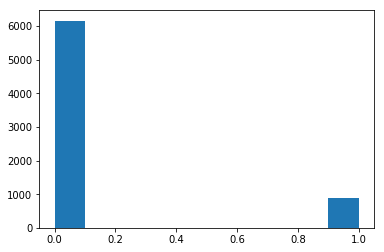

In [161]:
xdf = new_df.drop(['date'], axis=1)


neigh = KNeighborsClassifier(n_neighbors=3)

y = xdf['count']
X = xdf.drop('count', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)

#print(X)

neigh.fit(X_train, y_train)

y_pred = neigh.predict(X_test).reshape(-1, 1)
y_test = np.array(y_test).reshape(-1, 1)

print(neigh.score(X_test, y_test))
print(recall_score(y_test, y_pred))
plt.hist(xdf['count']);

In [133]:
def MVP(df):
    '''
    even more mvp than mvp
    '''
    
    y = df['count']
    X = df.drop('count', axis=1)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)
    
    
    linreg=LinearRegression()
    linreg.fit(X_train, y_train)
    
    y_pred = linreg.predict(X_test).reshape(-1,1)
    y_test = np.array(y_test).reshape(-1,1)
    
    #print(y_pred - y_test)
    print (np.shape(y_pred), np.shape(y_test))
    
    print(recall_score(y_test, y_pred))
    return linreg.score(X_test, y_test)


In [134]:
xdf = new_df.drop(['date'], axis=1)

In [135]:
MVP(xdf)

(1764, 1) (1764, 1)


ValueError: Classification metrics can't handle a mix of binary and continuous targets

In [ ]:
from sklearn.model_selection import TimeSeriesSplit

y = df['count']
X = df.loc[:, df.columns != 'count']

tscv = TimeSeriesSplit(n_splits=5)
print(tscv)  
TimeSeriesSplit(max_train_size=None, n_splits=5)
for train_index, test_index in tscv.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.iloc([train_index]), X.iloc([test_index])
    y_train, y_test = y[train_index], y[test_index]


In [ ]:
X = np.array([[1, 2], [3, 4], [1, 2], [3, 4],[1, 2], [3, 4],[3, 4],[1, 2],     [3, 4],[3, 4],[1, 2], [3, 4] ])
y = np.array([1, 2, 3, 4, 5, 6,7,8,9,10,11,12])
tscv = TimeSeriesSplit(n_splits=int((len(y)-3)/3))
for train_index, test_index in tscv.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)

    #To get the indices 
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]